# Training MixtureOfSVGPExperts on the Motorcycle Data Set (with two experts)

This notebook is a basic example of configuring and training a Mixture of Gaussian Process Experts (using `MixtureOfSVGPExperts`) on the motorcycle dataset with two experts. Instantiating the model with two experts is a special case because only a single gating function is needed (not two!) and the gating network can be calculated in closed form, which is not the case when using more than two experts. 

In [1]:
import numpy as np
import gpflow as gpf
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import clear_output

from gpflow import default_float
from gpflow.utilities import print_summary
from gpflow.likelihoods import Bernoulli

from mogpe.experts import SVGPExperts, SVGPExpert
from mogpe.gating_networks import SVGPGatingNetwork
from mogpe.mixture_of_experts import MixtureOfSVGPExperts
from mogpe.training import training_tf_loop
from mogpe.helpers.plotter import Plotter1D

Let's start by loading the motorcycle dataset and plotting it to see what we're dealing with.

In [2]:
def load_mcycle_dataset(filename='../data/mcycle.csv'):
    df = pd.read_csv(filename, sep=',')
    X = pd.to_numeric(df['times']).to_numpy().reshape(-1, 1)
    Y = pd.to_numeric(df['accel']).to_numpy().reshape(-1, 1)

    X = tf.convert_to_tensor(X, dtype=default_float())
    Y = tf.convert_to_tensor(Y, dtype=default_float())
    print("Input data shape: ", X.shape)
    print("Output data shape: ", Y.shape)

    # standardise input
    mean_x, var_x = tf.nn.moments(X, axes=[0])
    mean_y, var_y = tf.nn.moments(Y, axes=[0])
    X = (X - mean_x) / tf.sqrt(var_x)
    Y = (Y - mean_y) / tf.sqrt(var_y)
    data = (X, Y)
    return data

Input data shape:  (133, 1)
Output data shape:  (133, 1)


2021-12-08 18:27:42.245992: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


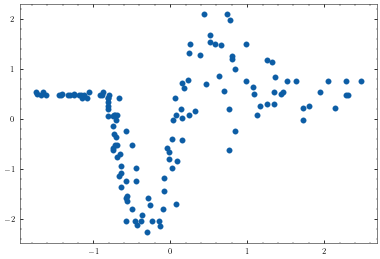

In [3]:
data_file = '../data/mcycle.csv'
dataset = load_mcycle_dataset(filename=data_file)
X, Y = dataset
num_data, input_dim = X.shape
output_dim = Y.shape[1]
plt.scatter(X, Y)

Given this data set, let's specify some of the model and training parameters. It is clear that there is a low noise, long lengthscales function at $x<-1$ and at $x>-1$ the noise increases and the lengthscale shortens. With this knowledge, let's initialise expert one with a short lengthscale and expert two with a longer lengthscale. We specify each expert to have 6 inducing points and the gating network to have 7 inducing points.

In [4]:
num_experts = 2
experts_lengthscales = [1.0, 10.0]  # lengthsales for expert 1 and 2
num_inducing_expert = 6  # number of inducing points for each expert
num_inducing_gating = 7  # number of inducing points for gating network
num_samples = 1  # number of samples to draw from variational posterior in ELBO
batch_size = 16
learning_rate = 0.01

In order to initialie the `MixtureOfSVGPExperts` class for two experts we must pass it an instance of `SVGPExperts` and an instance of `SVGPGatingNetwork` with a `Bernoulli` likelihood. Let's start by creating an instance of `SVGPExperts`. To do this we must first create two `SVGPExpert` instances and pass them as a list to `SVGPExperts`. Let's create out first expert. 

In [5]:
def init_expert(lengthscales=1.0, kernel_variance=1.0, noise_variance=1.0):
    idx = np.random.choice(range(num_data), size=num_inducing_expert, replace=False) 
    inducing_variable = X.numpy()[idx, ...].reshape(-1, input_dim)
    inducing_variable = gpf.inducing_variables.InducingPoints(inducing_variable)

    mean_function = gpf.mean_functions.Constant()
    likelihood = gpf.likelihoods.Gaussian(noise_variance)
    kernel = gpf.kernels.RBF(lengthscales=lengthscales, variance=kernel_variance)

    return SVGPExpert(kernel,
                      likelihood,
                      mean_function=mean_function,
                      inducing_variable=inducing_variable)

In [6]:
experts_list = [init_expert(lengthscales=experts_lengthscales[k]) for k in range(num_experts)]

We can now create an instance of `SVGPExperts` by passing our two experts as a list.

In [7]:
experts = SVGPExperts(experts_list)
print_summary(experts, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
SVGPExperts.experts_list[0].mean_function.c,Parameter,Identity,,True,"(1,)",float64,[0.]
SVGPExperts.experts_list[0].kernel.variance,Parameter,Softplus,,True,(),float64,1.0
SVGPExperts.experts_list[0].kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGPExperts.experts_list[0].likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGPExperts.experts_list[0].inducing_variable.Z,Parameter,Identity,,True,"(6, 1)",float64,[[-1.74116353...
SVGPExperts.experts_list[0].q_mu,Parameter,Identity,,True,"(6, 1)",float64,[[0....
SVGPExperts.experts_list[0].q_sqrt,Parameter,FillTriangular,,True,"(1, 6, 6)",float64,"[[[1., 0., 0...."
SVGPExperts.experts_list[1].mean_function.c,Parameter,Identity,,True,"(1,)",float64,[0.]
SVGPExperts.experts_list[1].kernel.variance,Parameter,Softplus,,True,(),float64,1.0
SVGPExperts.experts_list[1].kernel.lengthscales,Parameter,Softplus,,True,(),float64,10.0


Lovely stuff. We now need to create an instance of `SVGPGatingNetwork` with a `Bernoulli` likelihood. Remember that we only need a single gating function for the two expert case. Let's go ahead and create our gating function and use it to construct our gating network.

In [8]:
def init_gating_network():
    idx = np.random.choice(range(num_data), size=num_inducing_gating, replace=False) 
    inducing_variable = X.numpy()[idx, ...].reshape(-1, input_dim)
    inducing_variable = gpf.inducing_variables.InducingPoints(inducing_variable)

    mean_function = gpf.mean_functions.Zero()
    kernel = gpf.kernels.RBF()

    return SVGPGatingNetwork(kernel,
                             likelihood=Bernoulli(),
                             inducing_variable=inducing_variable,
                             mean_function=mean_function)

In [9]:
gating_network = init_gating_network()
print_summary(gating_network, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
SVGPGatingNetwork.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
SVGPGatingNetwork.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGPGatingNetwork.inducing_variable.Z,Parameter,Identity,,True,"(7, 1)",float64,[[-0.56402756...
SVGPGatingNetwork.q_mu,Parameter,Identity,,True,"(7, 1)",float64,[[0....
SVGPGatingNetwork.q_sqrt,Parameter,FillTriangular,,True,"(1, 7, 7)",float64,"[[[1., 0., 0...."


We now have all the components to construct our `MixtureOfSVGPExperts` model so let's go ahead and do it.

In [10]:
model = MixtureOfSVGPExperts(gating_network=gating_network, 
                             experts=experts, 
                             num_samples=num_samples,
                             num_data=num_data)
print_summary(model, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
MixtureOfSVGPExperts.gating_network.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
MixtureOfSVGPExperts.gating_network.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
MixtureOfSVGPExperts.gating_network.inducing_variable.Z,Parameter,Identity,,True,"(7, 1)",float64,[[-0.56402756...
MixtureOfSVGPExperts.gating_network.q_mu,Parameter,Identity,,True,"(7, 1)",float64,[[0....
MixtureOfSVGPExperts.gating_network.q_sqrt,Parameter,FillTriangular,,True,"(1, 7, 7)",float64,"[[[1., 0., 0...."
MixtureOfSVGPExperts.experts.experts_list[0].mean_function.c,Parameter,Identity,,True,"(1,)",float64,[0.]
MixtureOfSVGPExperts.experts.experts_list[0].kernel.variance,Parameter,Softplus,,True,(),float64,1.0
MixtureOfSVGPExperts.experts.experts_list[0].kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
MixtureOfSVGPExperts.experts.experts_list[0].likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
MixtureOfSVGPExperts.experts.experts_list[0].inducing_variable.Z,Parameter,Identity,,True,"(6, 1)",float64,[[-1.74116353...


We can use the Plotter1D class from `mogpe.helpers.plotter` to plot our model before training.  
- The top plot shows mixing probablility for each expert,
- Middle plots show each experts latent GP,
- The bottom plot shows the models posterior with the mean (black line) and samples (green dots).

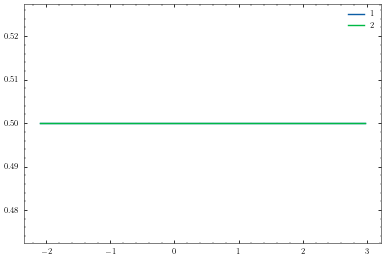

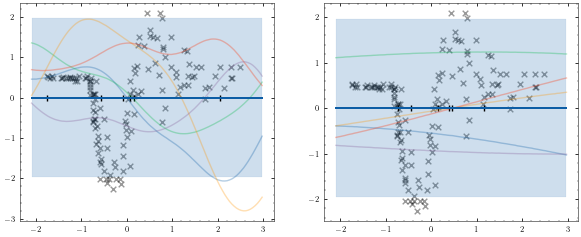

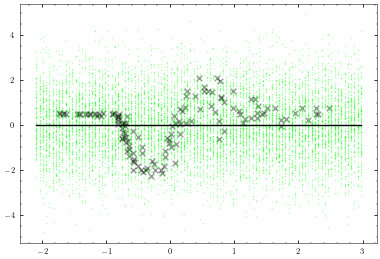

In [11]:
plotter = Plotter1D(model, X, Y)
plotter.plot_model()

We must now convert our numpy data set into a TensorFlow data set and set it up for stochastic optimisation by setting the batch size. We set drop_remainder=True to ensure the model receives the batch size.

In [12]:
prefetch_size = tf.data.experimental.AUTOTUNE
shuffle_buffer_size = num_data // 2
num_batches_per_epoch = num_data // batch_size
train_dataset = tf.data.Dataset.from_tensor_slices(dataset)
train_dataset = (train_dataset.repeat().prefetch(prefetch_size).shuffle(
    buffer_size=shuffle_buffer_size).batch(batch_size, drop_remainder=True))

We then use GPflows `training_loss_closure` method to get our training loss.

In [13]:
training_loss = model.training_loss_closure(iter(train_dataset))

In mogpe.training.training_loops some training loops are defined. Here we use the simple training_tf_loop which runs the Adam optimizer on model with training_loss as the objective function. The loop does not use any TensorBoard monitoring. We first configure the training/logging parameters.

In [14]:
logging_epoch_freq = 5
plotting_epoch_freq = 500
num_epochs = 2500

In [15]:
def plot_elbo(elbo):
    plt.subplot(111)
    plt.scatter(np.arange(len(elbo))*logging_epoch_freq, elbo)
    plt.xlabel("Epoch")
    plt.ylabel("ELBO")

Epoch 2500: ELBO (train) -12.587674046751173


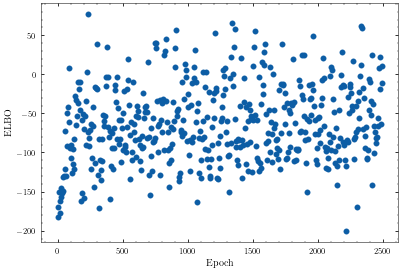

In [16]:
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

@tf.function
def tf_optimization_step():
    optimizer.minimize(training_loss, model.trainable_variables)

elbo_log = []
for epoch in range(num_epochs):
    for _ in range(num_batches_per_epoch):
        tf_optimization_step()
    epoch_id = epoch + 1
    if epoch_id % logging_epoch_freq == 0:
        elbo_log.append(training_loss()*-1.0)
    if epoch_id % plotting_epoch_freq == 0:
        clear_output(True)
        tf.print(f"Epoch {epoch_id}: ELBO (train) {training_loss()}")
        plot_elbo(elbo_log)
        plt.show()

Now that we have trained the model we can use our plotter again to visualise what we have learned.

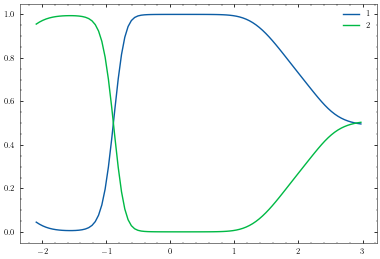

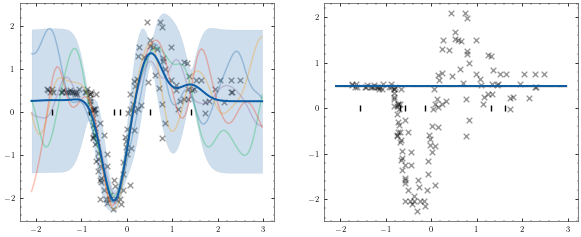

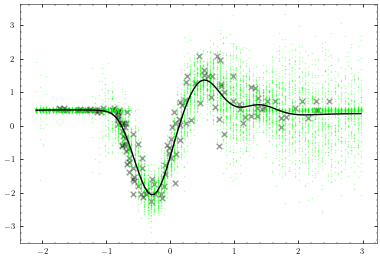

In [17]:
plotter.plot_model()

In [18]:
print_summary(model, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
MixtureOfSVGPExperts.gating_network.kernel.variance,Parameter,Softplus,,True,(),float64,10.044302011299953
MixtureOfSVGPExperts.gating_network.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.9191759962241284
MixtureOfSVGPExperts.gating_network.inducing_variable.Z,Parameter,Identity,,True,"(7, 1)",float64,[[-0.33679763...
MixtureOfSVGPExperts.gating_network.q_mu,Parameter,Identity,,True,"(7, 1)",float64,[[1.23060906...
MixtureOfSVGPExperts.gating_network.q_sqrt,Parameter,FillTriangular,,True,"(1, 7, 7)",float64,"[[[0.24373665, 0., 0...."
MixtureOfSVGPExperts.experts.experts_list[0].mean_function.c,Parameter,Identity,,True,"(1,)",float64,[0.2537413]
MixtureOfSVGPExperts.experts.experts_list[0].kernel.variance,Parameter,Softplus,,True,(),float64,0.7245331900215413
MixtureOfSVGPExperts.experts.experts_list[0].kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.266099322492376
MixtureOfSVGPExperts.experts.experts_list[0].likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.10439134246880631
MixtureOfSVGPExperts.experts.experts_list[0].inducing_variable.Z,Parameter,Identity,,True,"(6, 1)",float64,[[-0.82094873...
